In [1]:
from structures import *

In [82]:
#out_path = "../out_benches"
#out_path = "../out"
#out_path = "../test"
#out_path = "../out_binary"
#out_path = "../out_further"
#out_path = "../training/test_all"
#out_path = "../out_tanh"
#out_path = "../out_test"
#out_path = "../out_adiag"
#out_path = "../training/test_wtophat"
#out_path = "../out_srescale"
out_path = "../out_tanh2"

In [3]:
os.listdir(out_path)

['mnist_smorphnet_double_mse_opening_adiag_0',
 'mnist_smorphnet_double_mse_opening_adiag_1',
 'mnist_smorphnet_double_mse_closing_adiag_0',
 'mnist_smorphnet_double_mse_closing_adiag_1',
 'mnist_smorphnet_mse_dilation_adiag_0',
 'mnist_smorphnet_mse_dilation_adiag_1',
 'mnist_smorphnet_mse_erosion_adiag_0',
 'mnist_smorphnet_mse_erosion_adiag_1',
 'mnist_smorphnet_double_mse_opening_adiag_2',
 'mnist_smorphnet_double_mse_opening_adiag_3',
 'mnist_smorphnet_mse_dilation_iadiag_0',
 'mnist_smorphnet_double_mse_closing_iadiag_0',
 'mnist_smorphnet_double_mse_opening_iadiag_0',
 'mnist_smorphnet_mse_erosion_iadiag_0',
 'mnist_smorphnet_mse_erosion_iadiag_1',
 'mnist_smorphnet_mse_dilation_iadiag_1',
 'mnist_smorphnet_double_mse_closing_iadiag_1',
 'mnist_smorphnet_double_mse_opening_iadiag_1',
 'mnist_smorphnet_double_mse_closing_iadiag_2',
 'mnist_smorphnet_double_mse_opening_iadiag_2',
 'mnist_smorphnet_double_mse_closing_iadiag_3',
 'mnist_smorphnet_double_mse_opening_iadiag_3',
 'mnis

In [ ]:
sel_images = os.listdir(f"{out_path}/selems")
plt.subplots(figsize=(200, 200))
for i, sel_image in enumerate(sel_images):
    plt.subplot(1, len(sel_images) * 10, i + 1)
    plt.imshow(image.imread(f"{out_path}/selems/{sel_image}"))
    plt.title(sel_image[:-4])
    plt.axis('off')
plt.show()

In [4]:
def plot_filters(layer_name, var_name, layers, sel_idx, op, grid, fig, row, n_filters):
    l1_name = [ x for x in layers.keys() if f"{layer_name}1" in x ][0]
    if op == None:
        neg_weights = 1 if layers[l1_name][f'weights/{var_name}'][()].squeeze() > 0 else 0
    else:
        neg_weights = 1 if layer_name == "pconv" else ops[n_filters][op]
    l1 = layers[f"{l1_name}/weights/filter"][()] * 1 #(-1 + 2 * neg_weights)

    start_column = n_padding_column + global_column_size * sel_idx
    column_size = 1 if n_filters == 2 else 2 

    fig.add_subplot(grid[row, start_column:start_column + column_size], **plot_params)
    plt.imshow(l1.squeeze(), cmap='plasma')
    plt.title(f"{layers[l1_name][f'weights/{var_name}'][()].squeeze():.2f}")

    if n_filters == 2:
        l2_name = [ x for x in layers.keys() if f"{layer_name}2" in x ][0]
        if op == None:
            neg_weights = 0 if layers[l2_name][f'weights/{var_name}'][()].squeeze() > 0 else 1
        else:
            neg_weights = 0 if op == None or layer_name == "pconv" else neg_weights
        l2 = layers[f"{l2_name}/weights/filter"][()] * 1 #(1 - 2 * neg_weights)

        fig.add_subplot(grid[row, start_column + 1: start_column + 2], **plot_params)
        plt.imshow(l2.squeeze(), cmap='plasma')
        plt.title(f"{layers[l2_name][f'weights/{var_name}'][()].squeeze():.2f}")

In [84]:
def plot_lmorph(**kwargs):
    plot_filters("lm", "p", **kwargs)

def plot_smorph(**kwargs):
    plot_filters("sm", "alpha", **kwargs)

def plot_pconv(**kwargs):
    plot_filters("pconv", "p", **kwargs)

def print_meta(path, op, loss, n=None, current_loss=None, current_epoch=None, sel_name=True):
    print(f"{'operation:':<15} {op}")
    with h5py.File(f"{path}/vis/meta.h5", "r") as file:
        for key in meta_details:
            if not sel_name and (key == "sel_name" or key == "sel_size"):
                continue
            print(f"{key + ':':<15} {file[key][()]}")

        print()
        print(f"{'end_epoch' + ':':<15} {file['end_epoch'][()]}")
        print(f"{'end_reason' + ':':<15} {file['end_reason'][()]}")
        print(f"{'attained loss:':<15} {loss}")
        print()
        
        if n != None:
            print(f"{'current_loss' + ': ':<15} {current_loss}")
            print(f"{'current_epoch' + ': ':<15} {current_epoch}")
            

net_plots = { "lmorphnet_double": plot_lmorph,
              "pconvnet_double": plot_pconv,
              "smorphnet_double": plot_smorph,
              "lmorphnet": plot_lmorph,
              "pconvnet": plot_pconv,
              "smorphnet": plot_smorph }

In [85]:
# Creating the global grid
def init(nb_rows, coeff=2, print_selem=True):
    fig = plt.figure(constrained_layout=False,
                     figsize=(1 + nb_rows, coeff * (n_padding_column + len(selems) * global_column_size)),
                     dpi=50)
    grid = fig.add_gridspec(nrows=1 + nb_rows,
                            ncols=n_padding_column + len(selems) * global_column_size,
                            width_ratios=width_ratios,
                            left=0, right=2)

    # Filling selem row
    if print_selem:
        for i, sel_image in enumerate(selems):
            left_border = n_padding_column + i * global_column_size
            right_border = left_border + max_n_filter
            fig.add_subplot(grid[0, left_border:right_border], **plot_params)
            plt.imshow(image.imread(f"../out_benches/selems/{sel_image}.png"))
            plt.title(sel_image)

    params = { "grid": grid,
               "fig": fig,
               "row": 1 }
    
    return fig, grid, params

In [86]:
def plot(net_list, row, params, n_filters, run=0, dataset="mnist"):
    params["n_filters"] = n_filters

    for net in net_list:
        fig.add_subplot(grid[row:row + len(ops[n_filters].keys()), 0],
                        frameon=False,
                        **plot_params)
        plt.ylabel(net, fontweight='bold', fontsize=20)

        for op in ops[n_filters].keys():
            if op == "bclosing" or op == "wtophat" or op == "bopening" or op == "bdilation" or op == "berosion":
                continue
            
            params["op"] = op

            fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
            plt.ylabel(op, fontsize=15)
            for sel_idx, sel in enumerate(selems):
                path = f"{out_path}/{dataset}_{net}_mse_{op}_{sel}_{run}"
                n_batches = len(os.listdir(f"{path}/vis/batches/"))

                with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                    #print_meta(path, op, file['logs/loss'][()])
                    net_plots[net](layers=file['layers'], sel_idx=sel_idx, **params)

            row += 1
            params["row"] = row

    return row, params

FileNotFoundError: [Errno 2] No such file or directory: '../out_tanh2/mnist_pconvnet_double_mse_closing_cross3_9/vis/batches/'

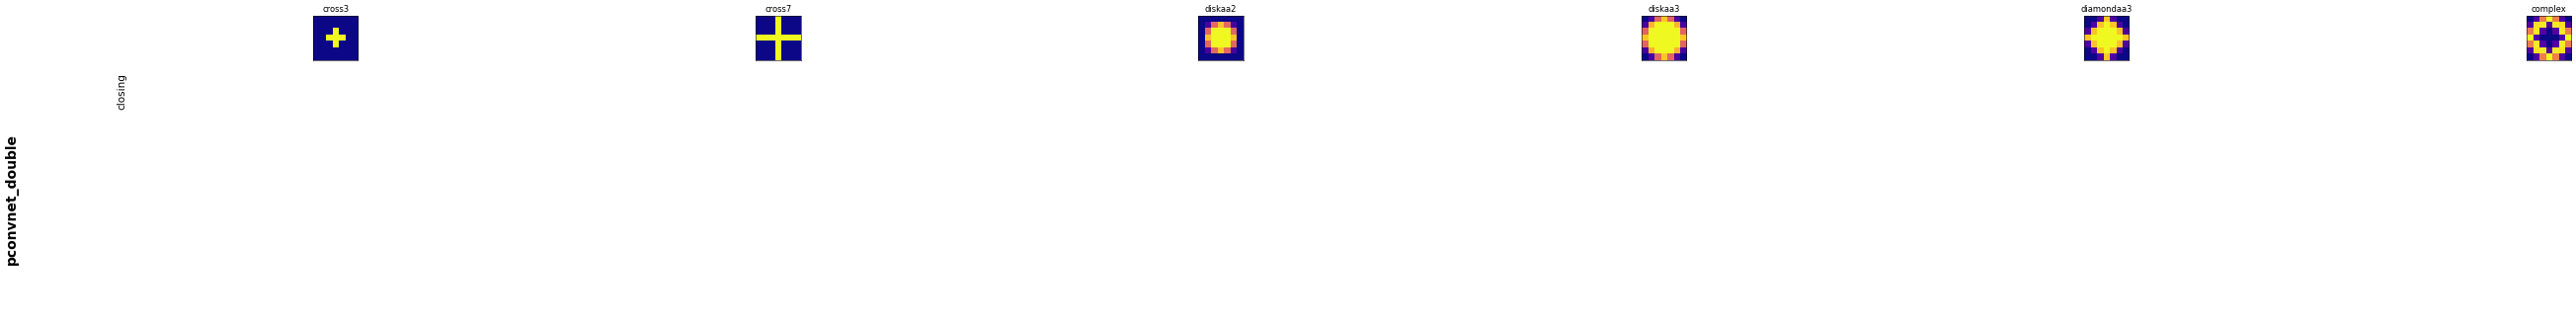

In [87]:
fig, grid, params = init(len(dnets) * len(dop) + len(snets) * len(sop))

row = 1

for n_filters, net_list in nets.items():
    row, params = plot(net_list, row, params, n_filters, 9)

plt.show()

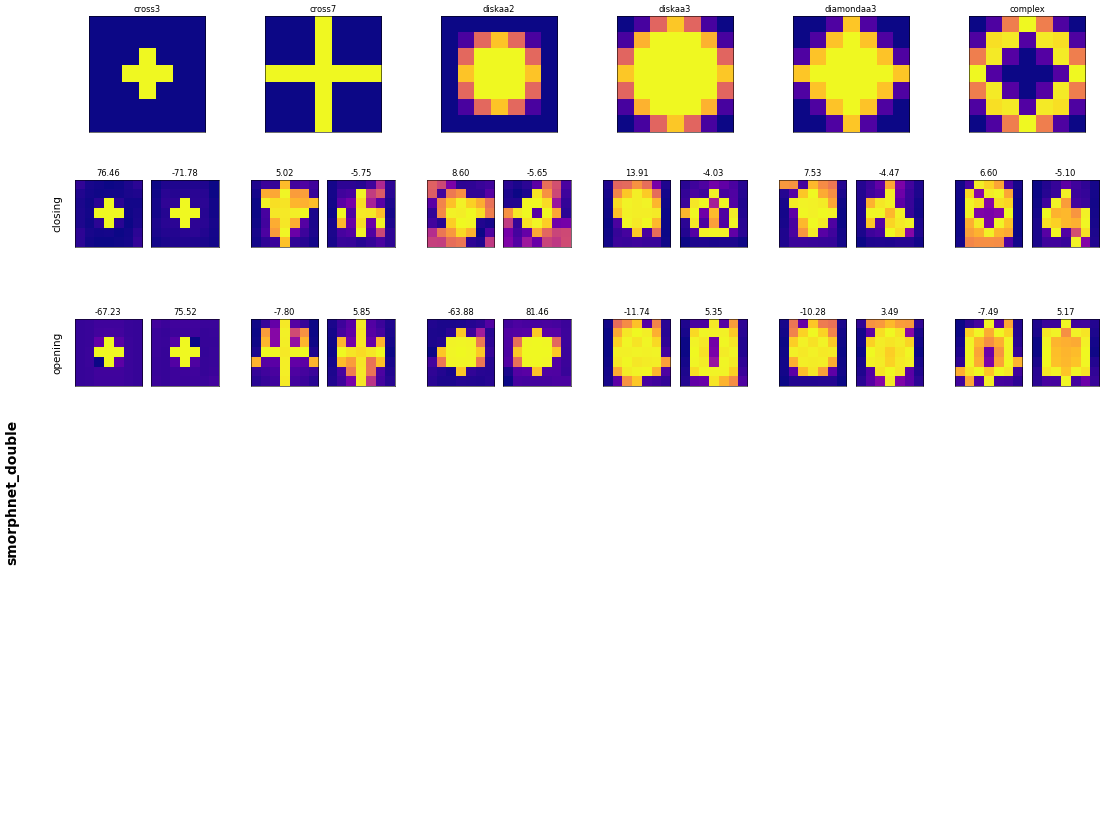

In [89]:
l=["smorphnet_double"]
fig, grid, params = init(2 * 1 * len(dop))

plot(net_list=l, row=1, params=params, n_filters=2, run=0, dataset="fashion_mnist")

plt.show()

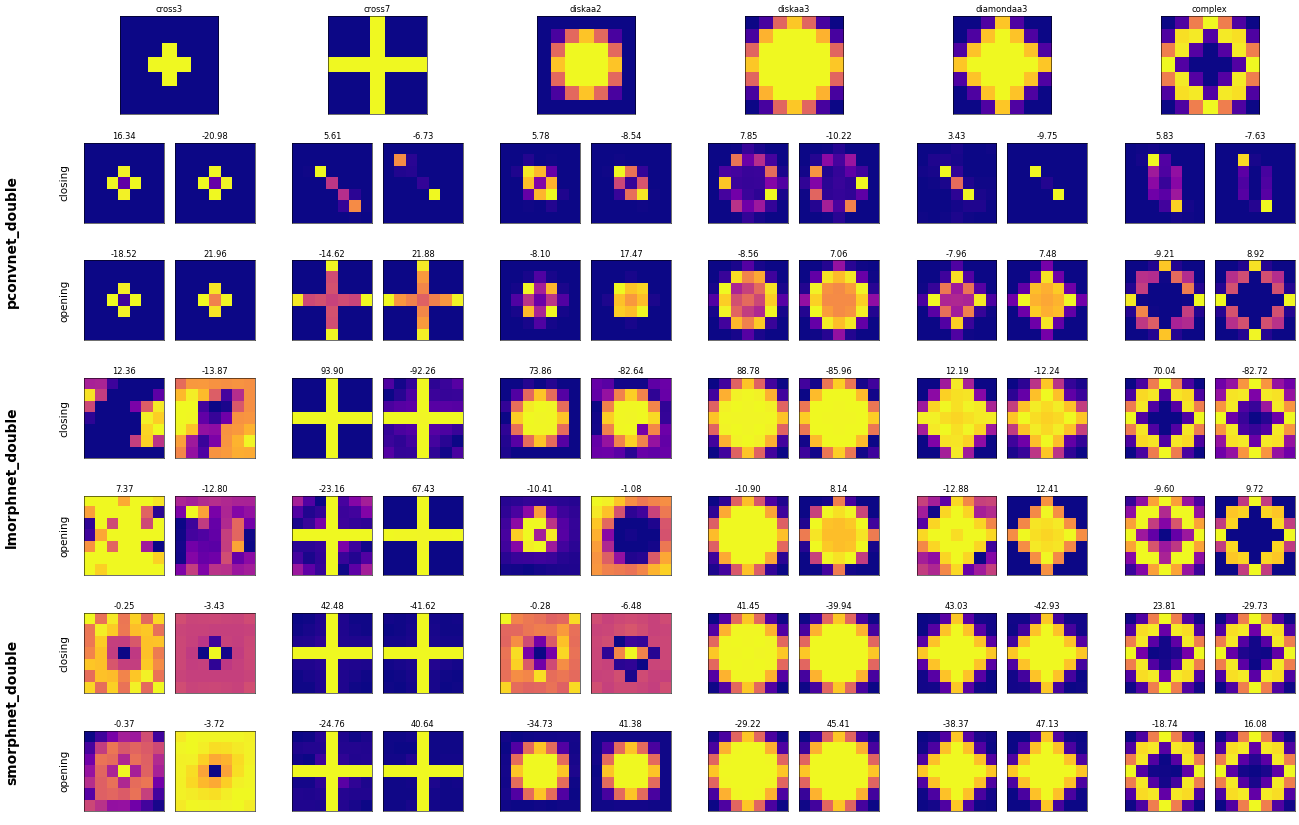

In [60]:
fig, grid, params = init(2 * (len(dnets) * len(dop)))

plot(dnets, 1, params, 2, 9)

plt.show()

In [11]:
def update(x, n_filters, op, var_name, layer_name, path):
    fig = plt.figure()
    with h5py.File(f"{path}/vis/batches/{x:06}.h5", "r") as file:
        #print("Lambda: ", file['layers/lmbda'][()][0])
        neg_weights = 1
        if op != None:
            neg_weights = 1 if layer_name == "pconv" else ops[n_filters][op]

        l1_name = [ x for x in file['layers'].keys() if f"{layer_name}1" in x ][0]
        if var_name == "":
            l1 = file['layers'][f"{l1_name}/weights/weight"][()].squeeze()
        else:
            l1 = file['layers'][f"{l1_name}/weights/filter"][()] * 1 #(-1 + 2 * neg_weights)

        ax = fig.add_subplot(1, n_filters, 1)
        p = ax.imshow(l1.squeeze(), cmap='plasma')
        if var_name != "":
            var = file['layers'][l1_name][f'weights/{var_name}'][()].squeeze()
            ax.set_title(f"{var:.2f}")
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(p, cax=cax)

        if n_filters == 2:
            neg_weights = 1
            if op != None:
                neg_weights = 0 if layer_name == "pconv" else neg_weights
            l2_name = [ x for x in file['layers'].keys() if f"{layer_name}2" in x ][0]
            if var_name == "":
                l2= file['layers'][f"{l2name}/weights/weight"][()].squeeze()
            else:
                l2 = file['layers'][f"{l2_name}/weights/filter"][()] * 1 #(1 - 2 * neg_weights)

            ax = fig.add_subplot(1, 2, 2)
            p = ax.imshow(l2.squeeze(), cmap='plasma')
            if var_name != "":
                var = file['layers'][l2_name][f'weights/{var_name}'][()].squeeze()
                ax.set_title(f"{var:.2f}")
            ax.axis('off')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(p, cax=cax)

        plt.show()

        sb1_name = [ x for x in file['layers'].keys() if "sb" in x ][0]
        print(f"bias: {file['layers'][f'{sb1_name}/weights/bias'][()].squeeze()}")
        print(f"weight: {file['layers'][f'{sb1_name}/weights/weight'][()].squeeze()}")
        print(f"min: {np.min(file['layers'][f'{l1_name}/weights/filter'][()])}")
        if x != 0:
            print(f"loss: {file['logs/loss'][()].squeeze()}")
        else:
            print(f"loss: inf")

def evolution(run, net, op, sel, dataset="mnist", out_path=""):
    path = f"{out_path}/{dataset}_{net}_mse_{op}_{sel}_{run}"
    #path = f"{out_path}/{dataset}_{net}_mse_{run}"
    n_batches = len(os.listdir(f"{path}/vis/batches/"))

    kwargs = { "n_filters": 1 if net in snets else 2,
               "op": op,
               "var_name": [ name for n, name in var_names.items() if n in net ][0],
               "layer_name": [ name for n, name in layer_names.items() if n in net ][0],
               "path": path }
    
    interact(lambda x : update(x, **kwargs), x=widgets.IntSlider(min=0, max=n_batches - 1, step=1, value=0))
    
    
def evolution2(run, net, dataset="mnist", out_path=".", loss="mse"):
    path = f"{out_path}/{dataset}_{net}_{loss}_{run}"
    n_batches = len(os.listdir(f"{path}/vis/batches/"))
    
    kwargs = { "n_filters": 1 if net in snets else 2,
               "op": None,
               "var_name": [ name for n, name in var_names.items() if n in net ][0],
               "layer_name": [ name for n, name in layer_names.items() if n in net ][0],
               "path": path }
    
    interact(lambda x : update(x, **kwargs), x=widgets.IntSlider(min=0, max=n_batches - 1, step=1, value=0))

In [151]:
evolution(1, "smorphnet_double", "opening", "diskaa2", "fashion_mnist", out_path="../out_norm")
#../test/fashion_mnist_smorphnet_mse_bdilation_bdiamond_1"

interactive(children=(IntSlider(value=0, description='x', max=585), Output()), _dom_classes=('widget-interact'…

In [158]:
evolution(1, "lmorphnet", "erosion", "complex", "mnist")

FileNotFoundError: [Errno 2] No such file or directory: '../out_binary/mnist_lmorphnet_mse_erosion_complex_1/vis/batches/'

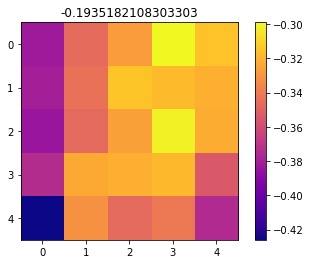

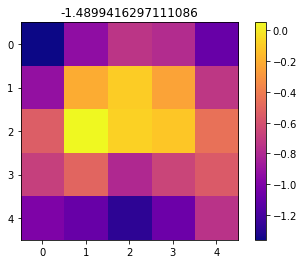

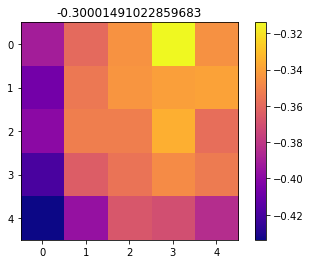

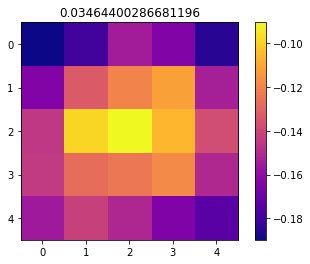

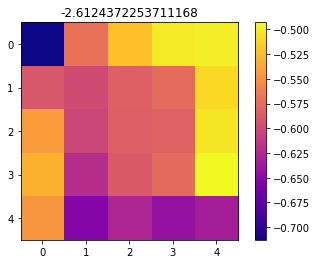

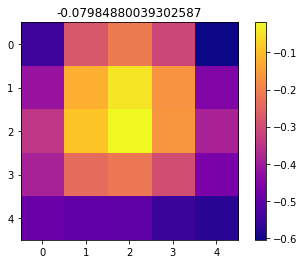

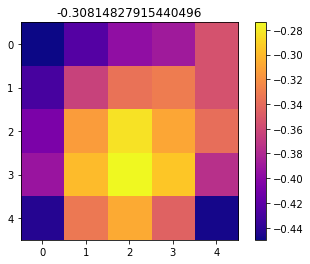

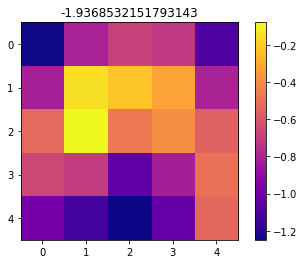

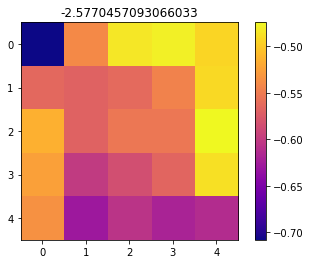

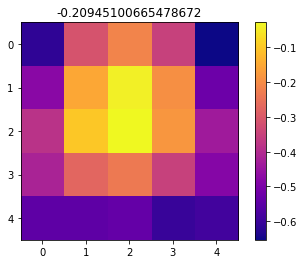

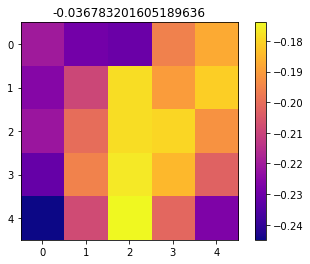

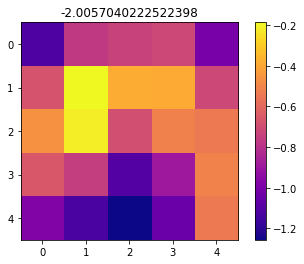

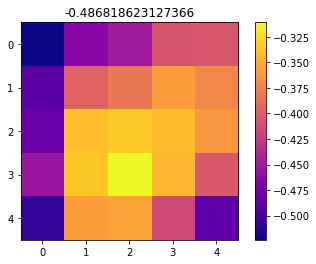

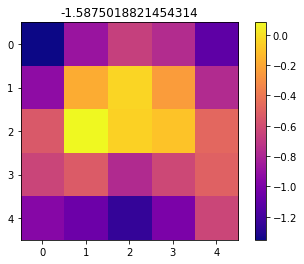

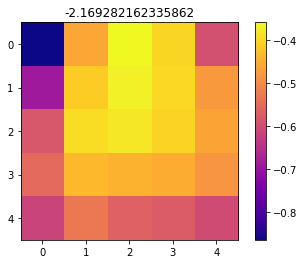

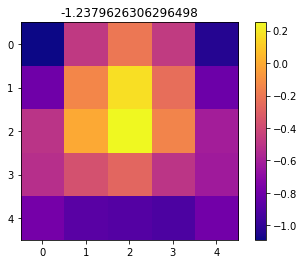

In [164]:
s = len(os.listdir("../training/out_classif/fashion_mnist_smorphnet_classif_crossentropy_19/vis/batches"))
with h5py.File(f"../training/out_classif/fashion_mnist_smorphnet_classif_crossentropy_19/vis/batches/{s - 1:06}.h5", "r") as file:
    layers = ['000_sm11', '001_sm12', '002_sm21', '003_sm22', '004_sm31', '005_sm32', '006_sm41', '007_sm42', '008_sm51', '009_sm52', '010_sm61', '011_sm62', '012_sm71', '013_sm72', '014_sm81', '015_sm82']
    for layer in layers:
        #print(file[f"layers/{layer}/weights/filter"].keys())
        plt.imshow(file[f"layers/{layer}/weights/filter"][()].squeeze(), cmap="plasma")
        plt.title(file[f"layers/{layer}/weights/alpha"][()].squeeze())
        plt.colorbar()
        plt.show()

In [94]:
def get_info(run, net, op, sel, n=None, dataset="mnist"):
        path = f"{out_path}/{dataset}_{net}_mse_{op}_{sel}_{run}"
        n_batches = len(os.listdir(f"{path}/vis/batches/"))

        with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            loss = file['logs/loss'][()]
            if n == None:
                print_meta(path, op, loss)
                return

        with h5py.File(f"{path}/vis/batches/{n:06}.h5", "r") as file:
            print_meta(path, op, loss, n, file['logs/loss'][()], file['logs/current_epoch'][()] - 1)

In [ ]:
get_info(12, "smorphnet_double", "opening", "diskaa3")

In [109]:
get_info(0, "smorphnet_double", "closing", "diskaa3", dataset="mnist")

operation:      closing
batch_size:     32
dataset:        mnist
loss:           mse
max_epochs:     1000
model:          models.smorphnet_double
patience:       10
sel_name:       diskaa3
sel_size:       7
vis_freq:       125



KeyError: "Unable to open object (object 'end_epoch' doesn't exist)"

In [156]:
evolution(2, "smorphnet_double", dataset="fashion_mnist", sel="complex", op="closing", out_path="../out_tanh2")#, loss="mse")

interactive(children=(IntSlider(value=0, description='x', max=425), Output()), _dom_classes=('widget-interact'…

In [47]:
#bias: -0.5129116649540328
#weight: 1.0132847069840778
#min: -1.3824450944628746
#loss: 2.8628863487779916e-05
path = f"{out_path}/mnist_smorphnet_double_mse_opening_complex_0"
n_batches = len(os.listdir(f"{path}/vis/batches/"))

with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    #print(file['layers'].keys())
    print(file['layers/lmbda'][()])

[-3.78168259]


In [65]:
def get_info_noise(run, net, op, percentage, n=None, dataset="mnist"):
        path = f"{out_path}/{dataset}_{net}_mse_{op}_{percentage}_{run}"
        n_batches = len(os.listdir(f"{path}/vis/batches/"))

        with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
            loss = file['logs/loss'][()]
            if n == None:
                print_meta(path, op, loss, sel_name=False)
                return

        with h5py.File(f"{path}/vis/batches/{n:06}.h5", "r") as file:
            print_meta(path, op, loss, n, file['logs/loss'][()], file['logs/current_epoch'][()] - 1)

(256, 256)
-0.3470949190010208 4.269868979968324
-2.1963929348377242e-16 0.9996899103329462


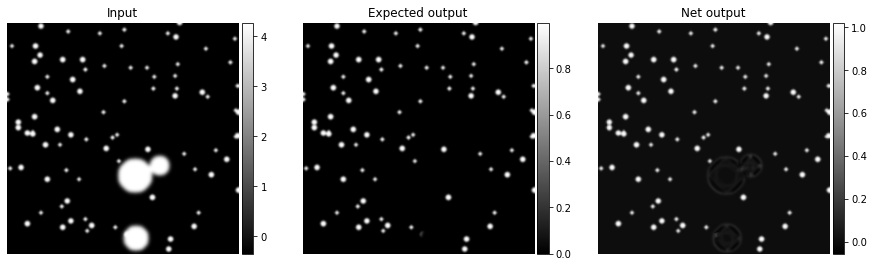

In [117]:
path = "../out_wtophat/gwtoh_smorphnet_double_mse_1"
fig = plt.figure(figsize=(15,15))
idx = 4
with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    
    ax = fig.add_subplot(131)
    p = ax.imshow(file["inputs"][()].squeeze()[idx], cmap='gray')
    print(file["inputs"][()].squeeze()[3].shape)
    mi = file["inputs"][()].squeeze().min()
    ma = file["inputs"][()].squeeze().max()
    print(mi, ma)
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Input")
    plt.colorbar(p, cax=cax)

    ax = fig.add_subplot(132)
    p = ax.imshow(file["targets"][()].squeeze()[idx], cmap='gray')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Expected output")
    plt.colorbar(p, cax=cax)
    
    mi = file["targets"][()].squeeze().min()
    ma = file["targets"][()].squeeze().max()
    print(mi, ma)
    
    n_batches = len(os.listdir(f"{path}/vis/batches/"))

with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    #ax = fig.add_subplot(133)
    #l1_name = [ x for x in file['layers'].keys() if f"sm2" in x ][0]
    #p = ax.imshow(file['layers'][f"{l1_name}/weights/filter"][()].squeeze(), cmap='plasma')
    #ax.axis('off')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(133)
    l1_name = [ x for x in file['layers'].keys() if "sb" in x ][0]
    p = ax.imshow(file['layers'][f"{l1_name}/output"][()].squeeze()[idx, :, :], cmap='gray')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Net output")
    plt.colorbar(p, cax=cax)
    
    
# -0.33984566947849437 3.487518278448532
# -0.28434809379445714 4.1479656154665925

prediction: 9


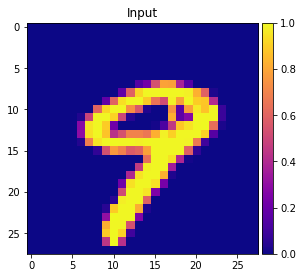

In [125]:
path = "../training/test_tttt/mnist_convnet_classif_crossentropy_14"
fig = plt.figure(figsize=(15,15))
idx = 9
with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    
    ax = fig.add_subplot(131)
    p = ax.imshow(file["inputs"][()].squeeze()[idx], cmap='plasma')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Input")
    plt.colorbar(p, cax=cax)

    
n_batches = len(os.listdir(f"{path}/vis/batches/"))

with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    print("prediction:", file['layers'][f"006_sigmoid/output"][()][idx].argmax())

In [ ]:
path = "../training/test_biwtoh/gwtoh_smorphnet_double_mse_3"
fig = plt.figure(figsize=(15,15))
with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    
    ax = fig.add_subplot(131)
    p = ax.imshow(file["inputs"][()].squeeze()[0], cmap='plasma')
    print(file["inputs"][()].squeeze()[3].shape)
    mi = file["inputs"][()].squeeze().min()
    ma = file["inputs"][()].squeeze().max()
    print(mi, ma)
    #ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Input")
    plt.colorbar(p, cax=cax)

n_batches = len(os.listdir(f"{path}/vis/batches/"))

with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    ax = fig.add_subplot(132)
    p = ax.imshow(file["targets"][()].squeeze()[0], cmap='plasma')
    #ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Expected output")
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(133)
    l1_name = [ x for x in file['layers'].keys() if f"sm2" in x ][0]
    p = ax.imshow(file['layers'][f"{l1_name}/weights/filter"][()].squeeze(), cmap='plasma')
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)
    
    ax = fig.add_subplot(144)
    l1_name = [ x for x in file['layers'].keys() if "sb" in x ][0]
    p = ax.imshow(file['layers'][f"{l1_name}/output"][()].squeeze()[0, :, :], cmap='gray')
    #ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Net output")
    plt.colorbar(p, cax=cax)

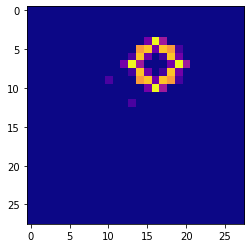

In [189]:
y = np.load('../training/y_all.npy')
y = y.squeeze()

plt.imshow(y[1], cmap='plasma')

In [ ]:
## get_info_noise(2, "smorphnet_double", "salt", 10, dataset="fashion_mnist")

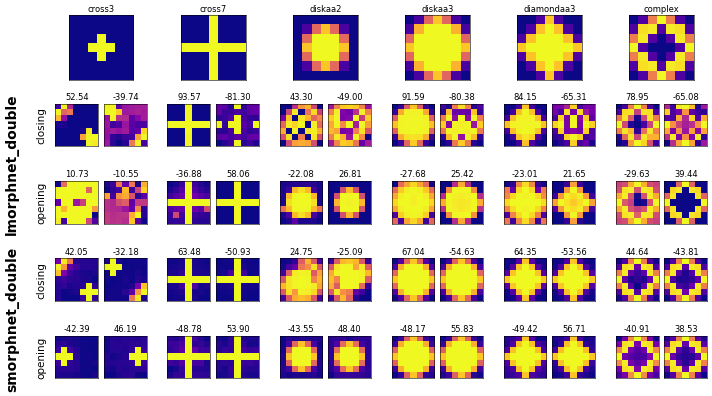

In [203]:
perso = ["lmorphnet_double", "smorphnet_double" ]
fig, grid, params = init(len(snets) * len(dop), coeff=0.7)

plot(perso, 1, params, 2, run=2, dataset="fashion_mnist")

plt.show()

In [61]:
def plot_filters_noise(layer_name, var_name, layers, sel_idx, op, grid, fig, row, n_filters, loss):
    l1_name = [ x for x in layers.keys() if f"{layer_name}1" in x ][0]
    l1 = layers[f"{l1_name}/output"][()][0]

    start_column = n_padding_column + global_column_size * sel_idx
    column_size = 1 if n_filters == 2 else 2

    fig.add_subplot(grid[row, start_column:start_column + column_size], **plot_params)
    plt.imshow(l1.squeeze(), cmap='plasma')
    plt.title(f"loss: {loss}")

    if n_filters == 2:
        l2_name = [ x for x in layers.keys() if f"{layer_name}2" in x ][0]
        l2 = layers[f"{l2_name}/output"][()][0]

        fig.add_subplot(grid[row, start_column + 1: start_column + 2], **plot_params)
        plt.imshow(l2.squeeze(), cmap='plasma')

def plot_lmorph_noise(**kwargs):
    plot_filters_noise("lm", "p", **kwargs)

def plot_smorph_noise(**kwargs):
    plot_filters_noise("sm", "alpha", **kwargs)

net_plots_noise = { "lmorphnet_double": plot_lmorph_noise,
                    "smorphnet_double": plot_smorph_noise,
                    "lmorphnet": plot_lmorph_noise,
                    "smorphnet": plot_smorph_noise }
    
# Creating the global grid
def init_noise(nets, percs, op="salt", dataset="fashion_mnist", net="smorphnet_double", coeff=2, print_selem=True):
    nb_rows = 2 * len(nets)
    width_ratios = np.ones(len(percs) * global_column_size + n_padding_column)
    width_ratios[0] /= 2
    width_ratios[1] /= 100
    width_ratios[n_padding_column + max_n_filter::global_column_size] /= 10
    
    fig = plt.figure(constrained_layout=False,
                     figsize=(coeff * (n_padding_column + len(percs) * global_column_size), 3 * (1 + nb_rows)),
                     dpi=50)
    grid = fig.add_gridspec(nrows=1 + nb_rows,
                            ncols=n_padding_column + len(percs) * global_column_size,
                            width_ratios=width_ratios,
                            left=0, right=2)

    # Filling selem row
    for i, perc in enumerate(percs):
        left_border = n_padding_column + i * global_column_size
        right_border = left_border + max_n_filter
        fig.add_subplot(grid[0, left_border:right_border], **plot_params)
        path = f"{out_path}/{dataset}_{net}_mse_{op}_{perc}_3"
        with h5py.File(f"{path}/vis/meta.h5", "r") as file:
            input = file["inputs"][()].squeeze()[0]
            crop_w, crop_h = 7 // 2, 7 // 2
            if "double" in net:
                crop_w *=2; crop_h *= 2
            plt.imshow(input[crop_h: input.shape[0] - crop_h, crop_w: input.shape[0] - crop_w], cmap='plasma')
        plt.title(f"{perc}%")

    params = { "grid": grid,
               "fig": fig,
               "row": 1 }
    
    return fig, grid, params

def plot_noise(net_list, row, params, n_filters, percs, op, run=0, dataset="mnist"):
    params["n_filters"] = n_filters
    params["op"] = None

    for net in net_list:
        fig.add_subplot(grid[row:row + 2, 0],
                        frameon=False,
                        **plot_params)
        plt.ylabel(net, fontweight='bold', fontsize=20)

        fig.add_subplot(grid[row:row + 1, 1], frameon=False, **plot_params)
        plt.ylabel("selem(s)", fontsize=15)
        fig.add_subplot(grid[row + 1:row + 2, 1], frameon=False, **plot_params)
        plt.ylabel("layer output", fontsize=15)

        for idx, perc in enumerate(percs):
            path = f"{out_path}/{dataset}_{net}_mse_{op}_{perc}_{run}"
            n_batches = len(os.listdir(f"{path}/vis/batches/"))

            with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
                net_plots[net](layers=file['layers'], sel_idx=idx, **params)
                params["row"] += 1
                net_plots_noise[net](layers=file['layers'], sel_idx=idx, loss=file['logs/loss'][()].squeeze(), **params)
                params["row"] -=1

        row += 2
        params["row"] = row

    return row, params

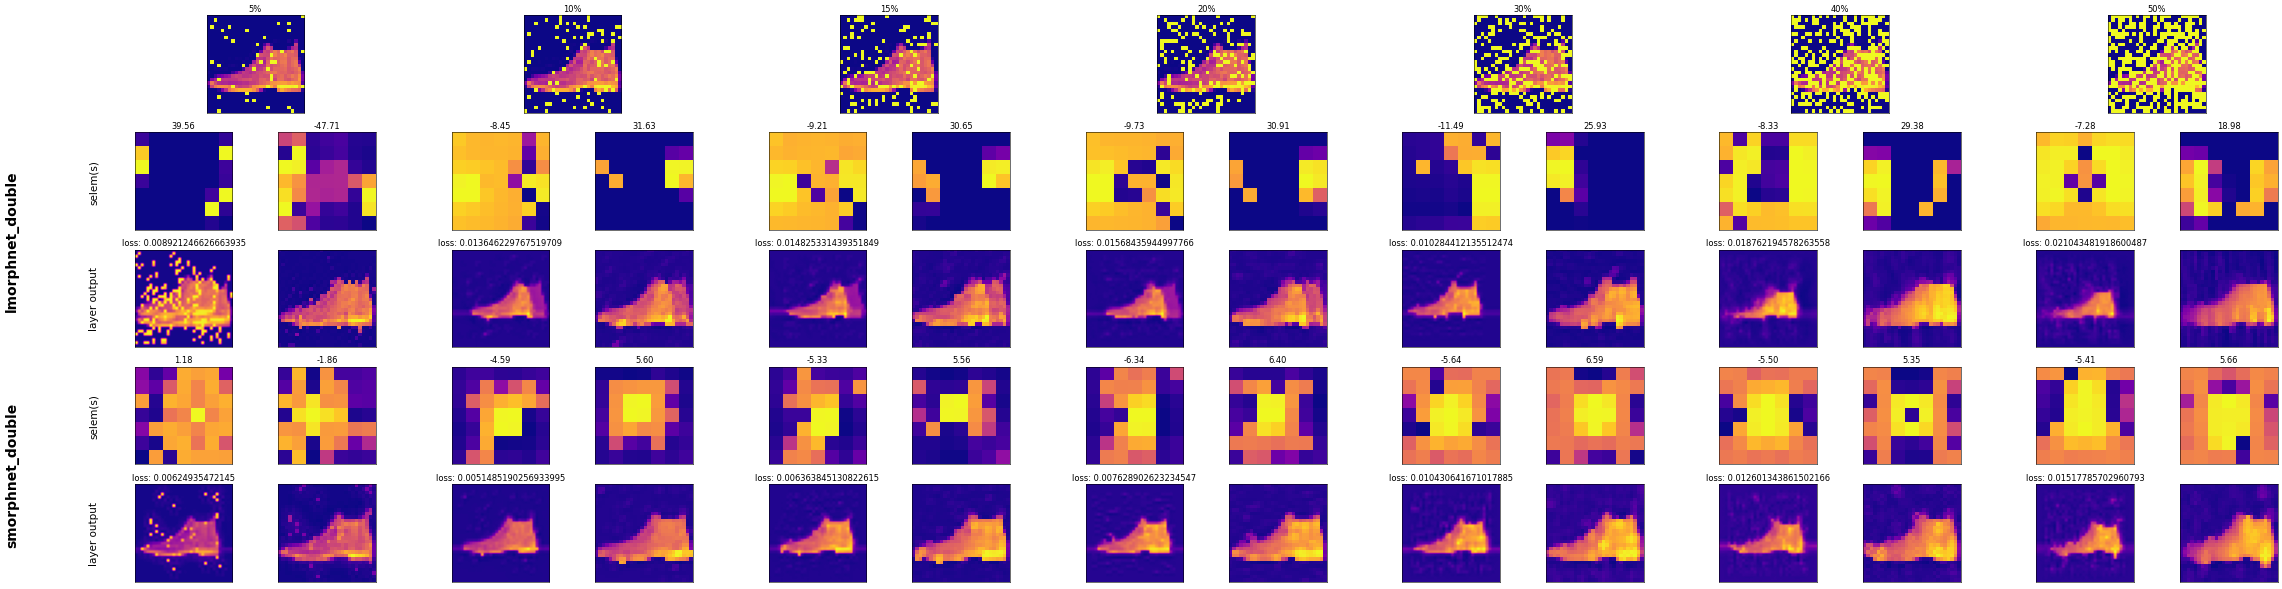

In [65]:
perso = ["lmorphnet_double", "smorphnet_double" ]
percs = [5, 10, 15, 20, 30, 40, 50]
fig, grid, params = init_noise(nets, percs, coeff=1, print_selem=False)

plot_noise(perso, 1, params, 2, percs, "salt", run=5, dataset="fashion_mnist")

plt.show()

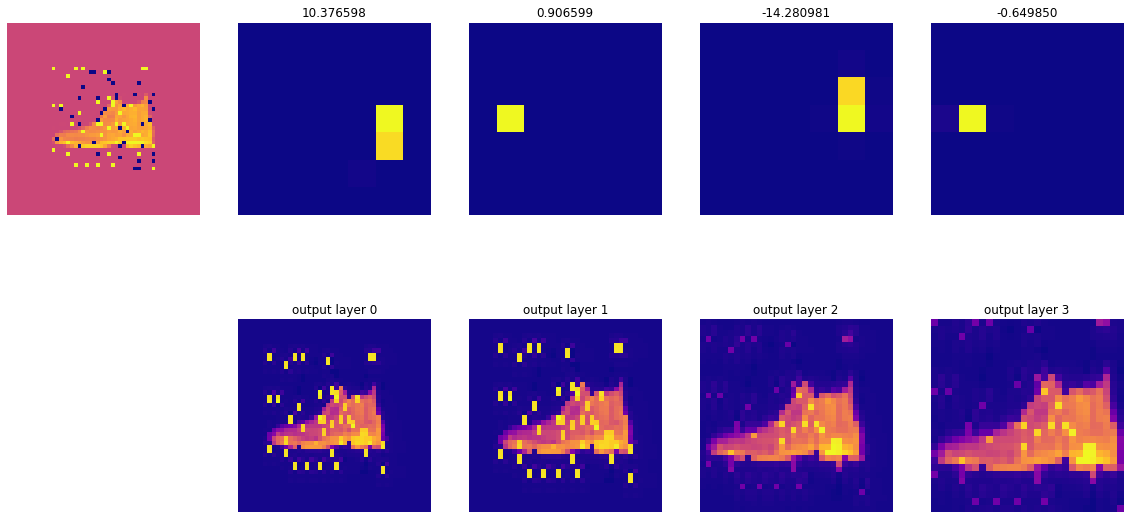

In [232]:
net = "pconvnet_four"
layer_name = "pconv"
var_name = "p"
noise = "saltpepper"
perc = 10
run = 0
dataset="fashion_mnist"
out_path = "../out_noise"

#path = f"{out_path}/{dataset}_{net}_mse_{op}_{sel}_{run}"
path = f"{out_path}/{dataset}_{net}_mse_{noise}_{perc}_{run}"
n_batches = len(os.listdir(f"{path}/vis/batches/"))

fig = plt.figure(figsize=(20,10))

with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    
    #plt.imshow(file['inputs'][()].squeeze()[0], cmap='plasma')
    #plt.colorbar()
    #plt.show()
        
    #plt.imshow(file['targets'][()].squeeze()[0], cmap='plasma')
    #plt.colorbar()
    #plt.show()

    plt.subplot(2, 5, 1)
    plt.axis('off')
    plt.imshow(file['inputs'][()].squeeze()[0], cmap='plasma')
with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    for i, layer in enumerate(list(file['layers'].keys())[:-1]):
        plt.subplot(2, 5, 2 + i)
        plt.axis('off')
        plt.imshow(file[f'layers/{layer}/weights/filter'][()].squeeze(), cmap='plasma')
        plt.title(f'{file[f"layers/{layer}/weights/{var_name}"][()].squeeze():3f}')
        plt.subplot(2, 5, 7 + i)
        plt.axis('off')
        plt.imshow(file[f'layers/{layer}/output'][()].squeeze()[0], cmap='plasma')
        plt.title(f'output layer {i}')

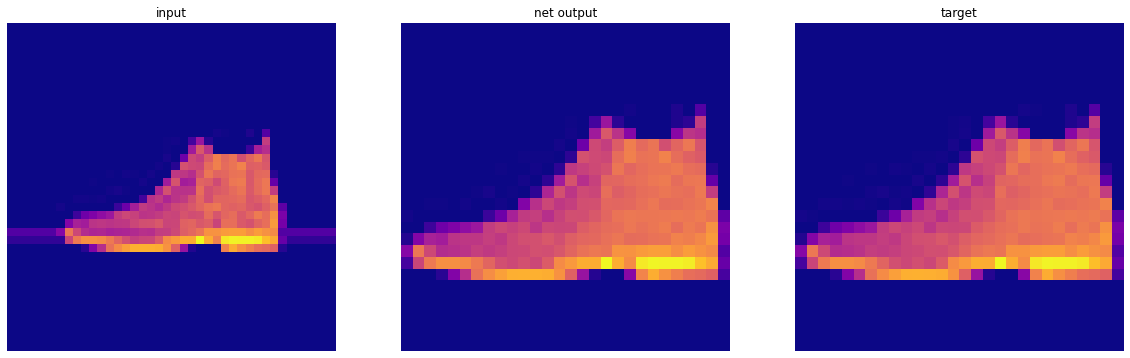

In [68]:
net = "smorphnet_double"
layer_name = "sm"
var_name = "alpha"
noise = "salt"
op = "closing"
sel = "complex"
perc = 50
run = 0
dataset="fashion_mnist"

path = f"../out_fmnist/{dataset}_{net}_mse_{op}_{sel}_{run}"
#path = f"{out_path}/{dataset}_{net}_mse_{noise}_{perc}_{run}"
n_batches = len(os.listdir(f"{path}/vis/batches/"))

fig = plt.figure(figsize=(20,10))

with h5py.File(f"{path}/vis/meta.h5", "r") as file:
    noised = file['inputs'][()].squeeze()[0]
    plt.subplot(131)
    plt.imshow(noised, cmap='plasma')
    plt.title('input')
    plt.axis('off')
    target = file['targets'][()].squeeze()[0]
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(target, cmap='plasma')
    plt.title('target')
with h5py.File(f"{path}/vis/batches/{n_batches - 1:06}.h5", "r") as file:
    layer = [ x for x in file['layers'].keys() if f"{layer_name}2" in x ][0]
    denoised = file[f'layers/{layer}/output'][()].squeeze()[0]
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(denoised, cmap='plasma')
    plt.title('net output')

In [219]:
n = (noised - np.min(noised)) / (np.max(noised) - np.min(noised))
d = (denoised - np.min(denoised)) / (np.max(denoised) - np.min(denoised))

print(f"SNR noised: {20 * np.log10(1 / np.mean((noised[6:-6, 6:-6] - target)**2))}")
print(f"SNR denoised: {20 * np.log10(1 / np.mean((denoised - target)**2))}")
print(f"SNR noised [0;1]: {20 * np.log10(1 / np.mean((n[6:-6, 6:-6] - target)**2))}")
print(f"SNR denoised [0;1]: {20 * np.log10(1 / np.mean((d - target)**2))}")

SNR noised: 22.072765985606093
SNR denoised: 45.82752605743807
SNR noised [0;1]: 22.072765985606093
SNR denoised [0;1]: 50.584270170125045
